## Config and Libraries

In [ ]:
DEBUG = False

In [ ]:
# libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as L
from kaggle_datasets import KaggleDatasets
import tensorflow_addons as tfa

print(tf.__version__)

2.4.1


In [ ]:
enet_type = tf.keras.applications.EfficientNetB1
num_classes = 12
num_ett_classes = 4
num_other_classes = num_classes - num_ett_classes
n_ch = 5
image_size = 512
batch_size = 128 # original is 32
init_lr = 3e-4
warmup_epo = 1
# If DEBUG == True, only run 3 epochs per fold
cosine_epo = 29 if not DEBUG else 2
n_epochs = warmup_epo + cosine_epo
loss_weights = [1., 9.]

VID = "V19"
FOLD_I_LIST=[0]

In [ ]:
ranzcr_train_data_name = 'ranzcr-1st-place-solution-by-tf-train-data'

## TPU

In [ ]:
try: # detect TPUs
    # NEW: in Tensorflow 2.4
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() 
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # otherwise detect GPUs
    strategy = tf.distribute.MirroredStrategy() # single-GPU or multi-GPU
    
print(f"Running on {strategy.num_replicas_in_sync} replicas")

Running on 8 replicas


In [ ]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path(ranzcr_train_data_name)

GCS_DS_PATH

'gs://kds-e47f1f2d8e8e111e02374d44f665c5d21ff16e06ab722f2449d6f91d'

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

## Dataset

In [ ]:
def decode_image(image_bytes):
    image = tf.image.decode_jpeg(image_bytes, channels=3)
    image = tf.reshape(image, (image_size, image_size, 3))
    return image

def decode_mask(mask_bytes):
    mask = tf.io.decode_png(mask_bytes, channels=3)
    mask = tf.reshape(mask, (image_size, image_size, 3))
    return mask

def read_tfrecord(example):
    TFREC_FORMAT = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'mask': tf.io.FixedLenFeature([], tf.string),
        'ETT - Abnormal': tf.io.FixedLenFeature([], tf.int64),
        'ETT - Borderline': tf.io.FixedLenFeature([], tf.int64),
        'ETT - Normal': tf.io.FixedLenFeature([], tf.int64),
        'NGT - Abnormal': tf.io.FixedLenFeature([], tf.int64),
        'NGT - Borderline': tf.io.FixedLenFeature([], tf.int64),
        'NGT - Incompletely Imaged': tf.io.FixedLenFeature([], tf.int64),
        'NGT - Normal': tf.io.FixedLenFeature([], tf.int64),
        'CVC - Abnormal': tf.io.FixedLenFeature([], tf.int64),
        'CVC - Borderline': tf.io.FixedLenFeature([], tf.int64),
        'CVC - Normal': tf.io.FixedLenFeature([], tf.int64),
        'Swan Ganz Catheter Present': tf.io.FixedLenFeature([], tf.int64),
        'fold': tf.io.FixedLenFeature([], tf.int64),
    }
    
    example = tf.io.parse_single_example(example, TFREC_FORMAT)
    image = decode_image(example['image'])
    mask = decode_mask(example['mask'])
    ett_abnormal = example['ETT - Abnormal']
    ett_borderline = example['ETT - Borderline']
    ett_normal = example['ETT - Normal']
    # Add no_ett, 1 when all ett_xxx are 0
    no_ett = 1 - tf.math.reduce_max([
        ett_abnormal, ett_borderline, ett_normal])
    ngt_abnormal = example['NGT - Abnormal']
    ngt_borderline = example['NGT - Borderline']
    ngt_inc_imaged = example['NGT - Incompletely Imaged']
    ngt_normal = example['NGT - Normal']
    cvc_abnormal = example['CVC - Abnormal']
    cvc_borderline = example['CVC - Borderline']
    cvc_normal = example['CVC - Normal']
    swan_ganz_cat_present = example['Swan Ganz Catheter Present']
    fold = example['fold']

    labels_ett = [
        ett_abnormal, ett_borderline, ett_normal, no_ett ]
    labels_other = [
        ngt_abnormal, ngt_borderline, ngt_inc_imaged, ngt_normal,
        cvc_abnormal, cvc_borderline, cvc_normal,
        swan_ganz_cat_present ]
    labels_pred = [
        ett_abnormal, ett_borderline, ett_normal, # no no_ett
        ngt_abnormal, ngt_borderline, ngt_inc_imaged, ngt_normal,
        cvc_abnormal, cvc_borderline, cvc_normal,
        swan_ganz_cat_present ]
    labels = (labels_ett, labels_other, labels_pred)
    
    return image, mask, labels, fold

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=None)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=None)
    return dataset

In [ ]:
tfrec_file_names = tf.io.gfile.glob(GCS_DS_PATH + '/*.tfrec')
tfrec_file_names = \
    [ tfrec_file_names[0] ] if DEBUG else tfrec_file_names
raw_ds = load_dataset(tfrec_file_names)

print(raw_ds)

<MapDataset shapes: ((512, 512, 3), (512, 512, 3), ((4,), (8,), (11,)), ()), types: (tf.uint8, tf.uint8, (tf.int64, tf.int64, tf.int64), tf.int64)>


In [ ]:
folds_list = []
for _, _, _, fold_batch in raw_ds.batch(256):
    print('.', end='', flush=True)
    folds_list.append(fold_batch)

folds = np.concatenate(folds_list)
fold, counts = np.unique(folds, return_counts=True)
fold_count_dict = dict(zip(fold, counts))

fold_count_dict

......................................................................................................................

{0: 5990, 1: 6028, 2: 6032, 3: 6018, 4: 6015}

In [ ]:
def fold_train_count(fold_i):
    counts = [ 
        count for fold, count in fold_count_dict.items() \
        if fold != fold_i ]
    return sum(counts)

def fold_val_count(fold_i):
    return fold_count_dict[fold_i]

## Augmentations

### Utilities

In [ ]:
def image_mask_to_float_0_1(image, mask):
    image = tf.cast(image, dtype=tf.float32) / 255.0
    mask = tf.cast(mask, dtype=tf.float32) / 255.0
    return image, mask

def image_mask_to_uint8(image, mask):
    image = tf.cast(image * 255.0, dtype=tf.uint8)
    mask = tf.cast(mask * 255.0, dtype=tf.uint8)
    return image, mask

In [ ]:
def check_aug(aug_fun, with_mask):
    image, mask, _, _ = next(iter(raw_ds.take(1)))
    image, mask = image_mask_to_float_0_1(image, mask)
    
    plt.figure(figsize=(12, 4))
    rows = 2
    cols = 5
    aug_masks = []
    for p in range(rows*cols):
        aug_image, aug_mask = aug_fun(image, mask)
        aug_image, aug_mask = image_mask_to_uint8(aug_image, aug_mask)
        aug_masks.append(aug_mask)
        
        plt.subplot(rows, cols, p+1)
        plt.imshow(aug_image)
        plt.axis("off")
    plt.tight_layout()
    plt.show()        
    
    if with_mask:
        plt.figure(figsize=(12, 4))
        for p, aug_mask in enumerate(aug_masks):
            plt.subplot(rows, cols, p+1)
            plt.imshow(aug_mask)
            plt.axis("off")
        plt.tight_layout()
        plt.show()

In [ ]:
def random_float(minval=0.0, maxval=1.0):
    rnd = tf.random.uniform(
        [], minval=minval, maxval=maxval, dtype=tf.float32)
    return rnd

def choice(p, image1, mask1, image2, mask2):
    rnd = random_float()
    image = tf.where(rnd <= p, image1, image2)
    mask = tf.where(rnd <= p, mask1, mask2)
    return image, mask

In [ ]:
 def mirror_boundary(v, max_v):
    # v % (max_v*2.0-2.0) ==> v % (512*2-2) ==> [0..1022]
    # [0..1022] - (max_v-1.0) ==> [0..1022] - 511 ==> [-511..511]
    # -1.0 * abs([-511..511]) ==> [-511..0]
    # [-511..0] + max_v - 1.0 ==> [-511..0] + 511 ==> [0..511]
    mirror_v = -1.0 * tf.math.abs(
        v % (max_v*2.0-2.0) - (max_v-1.0)) + max_v-1.0
    return mirror_v

def clip_boundary(v, max_v):
    clip_v = tf.clip_by_value(v, 0.0, max_v-1.0)
    return clip_v

def interpolate_bilinear(image, map_x, map_y):
    def _gather(image, map_x, map_y):
        map_stack = tf.stack([map_x, map_y]) # [ 2, height, width ]
        map_indices = tf.transpose(
            map_stack, perm=[1, 2, 0])       # [ height, width, 2 ]
        map_indices = tf.cast(map_indices, dtype=tf.int32)
        gather_image = tf.gather_nd(image, map_indices)
        return gather_image
    
    ll = _gather(image, tf.math.floor(map_x), tf.math.floor(map_y))
    lr = _gather(image, tf.math.ceil(map_x), tf.math.floor(map_y))
    ul = _gather(image, tf.math.floor(map_x), tf.math.ceil(map_y))
    ur = _gather(image, tf.math.ceil(map_x), tf.math.ceil(map_y))
    
    fraction_x = tf.expand_dims(map_x % 1.0, axis=-1) # [h, w, 1]
    int_l = (lr - ll) * fraction_x + ll
    int_u = (ur - ul) * fraction_x + ul
    
    fraction_y = tf.expand_dims(map_y % 1.0, axis=-1) # [h, w, 1]
    interpolate_image = (int_u - int_l) * fraction_y + int_l
    return interpolate_image

def remap(image, height, width, map_x, map_y, mode):
    assert \
        mode in ('mirror', 'constant'), \
        "mode is neither 'mirror' nor 'constant'"

    height_f = tf.cast(height, dtype=tf.float32)
    width_f = tf.cast(width, dtype=tf.float32)
    map_x = tf.reshape(map_x, shape=[height, width])
    map_y = tf.reshape(map_y, shape=[height, width])
    if mode == 'mirror':
        b_map_x = mirror_boundary(map_x, width_f)
        b_map_y = mirror_boundary(map_y, height_f)
    else:
        b_map_x = clip_boundary(map_x, width_f)
        b_map_y = clip_boundary(map_y, height_f)
        
    image_remap = interpolate_bilinear(image, b_map_x, b_map_y)
    
    if mode == 'constant':
        map_stack = tf.stack([map_x, map_y])
        map_indices = tf.transpose(map_stack, perm=[1, 2, 0])
        x_ge_0 = (0.0 <= map_indices[ : , : , 0])    # [h, w]
        x_lt_w = (map_indices[ : , : , 0] < width_f)
        y_ge_0 = (0.0 <= map_indices[ : , : , 1])
        y_lt_h = (map_indices[ : , : , 1] < height_f)
        inside_boundary = tf.math.reduce_all(
            tf.stack([x_ge_0, x_lt_w, y_ge_0, y_lt_h]), axis=0) # [h, w]
        inside_boundary = inside_boundary[ : , : , tf.newaxis]  # [h, w, 1]
        image_remap = tf.where(inside_boundary, image_remap, 0.0)

    return image_remap

### HorizontalFlip

In [ ]:
def HorizontalFlip(p):
    def _do_horizontal_flip(image, mask):
        aug_image = tf.image.flip_left_right(image)
        aug_mask = tf.image.flip_left_right(mask)
        return choice(p, aug_image, aug_mask, image, mask)
    return _do_horizontal_flip

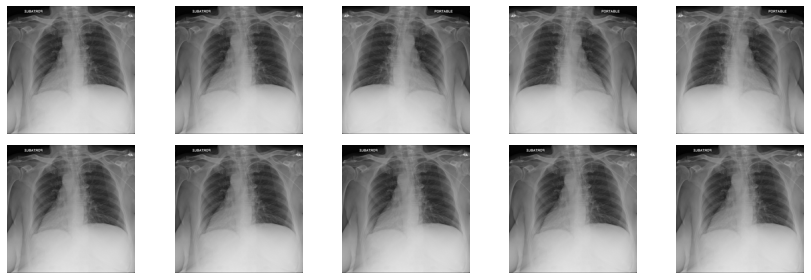

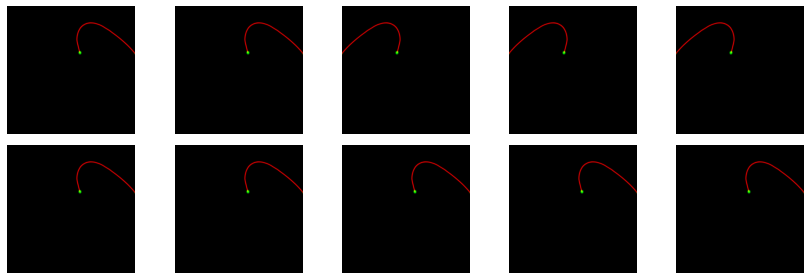

In [ ]:
horizontal_flip = HorizontalFlip(p=0.5)
check_aug(horizontal_flip, with_mask=True)

### RandomBrightness

In [ ]:
def RandomBrightness(max_delta, p):
    def _do_random_brightness(image, mask):
        aug_image = tf.image.random_brightness(image, max_delta)
        return choice(p, aug_image, mask, image, mask)
    return _do_random_brightness

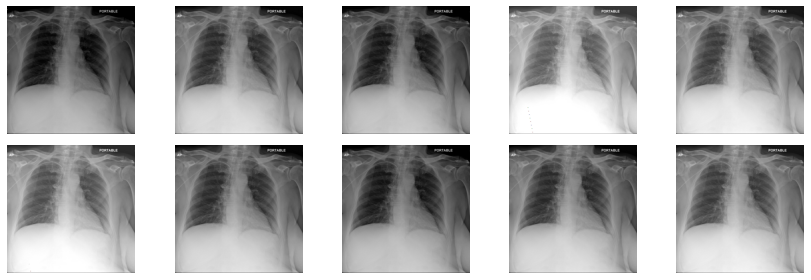

In [ ]:
random_brightness = RandomBrightness(max_delta=0.2, p=0.75)
check_aug(random_brightness, with_mask=False)

### RandomContrast

In [ ]:
def RandomContrast(lower, upper, p):
    def _do_random_contrast(image, mask):
        aug_image = tf.image.random_contrast(image, lower, upper)
        return choice(p, aug_image, mask, image, mask)
    return _do_random_contrast

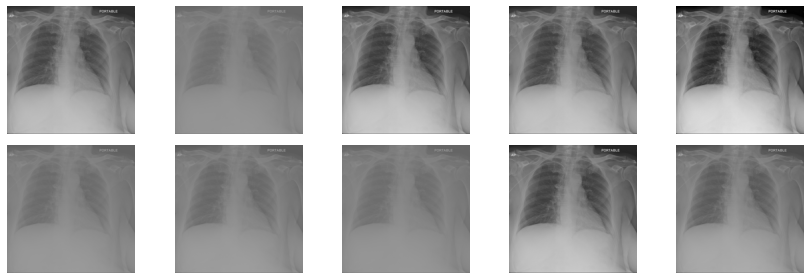

In [ ]:
random_contrast = RandomContrast(lower=0.2, upper=0.8, p=0.75)
check_aug(random_contrast, with_mask=False)

### OpticalDistortion

initUndistortRectifyMap -- https://docs.opencv.org/3.4/da/d54/group__imgproc__transform.html#ga7dfb72c9cf9780a347fbe3d1c47e5d5a


In [ ]:
def initUndistortRectifyMap(height, width, k, dx, dy):
    height = tf.cast(height, dtype=tf.float32)
    width = tf.cast(width, dtype=tf.float32)
    
    f_x = width
    f_y = height
    c_x = width * 0.5 + dx
    c_y = height * 0.5 + dy
    
    f_dash_x = f_x
    c_dash_x = (width - 1.0) * 0.5
    f_dash_y = f_y
    c_dash_y = (height - 1.0) * 0.5

    h_rng = tf.range(height, dtype=tf.float32)
    w_rng = tf.range(width, dtype=tf.float32)
    v, u = tf.meshgrid(h_rng, w_rng)
    
    x = (u - c_dash_x) / f_dash_x
    y = (v - c_dash_y) / f_dash_y
    x_dash = x
    y_dash = y
    
    r_2 = x_dash * x_dash + y_dash * y_dash
    r_4 = r_2 * r_2
    x_dash_dash = x_dash * (1 + k*r_2 + k*r_4)
    y_dash_dash = y_dash * (1 + k*r_2 + k*r_4)

    map_x = x_dash_dash * f_x + c_x
    map_y = y_dash_dash * f_y + c_y
    return map_x, map_y

In [ ]:
def OpticalDistortion(distort_limit, shift_limit, p=1.0):
    def _do_optical_distortion(image, mask):
        k = random_float(-distort_limit, distort_limit)
        dx = random_float(-shift_limit, shift_limit)
        dy = random_float(-shift_limit, shift_limit)
        image_shape = tf.shape(image)
        height = image_shape[0]
        width = image_shape[1]
        map_x, map_y = initUndistortRectifyMap(
            height, width, k, dx, dy)
        aug_image = remap(
            image, height, width, map_x, map_y, mode='mirror')
        aug_mask = remap(
            mask, height, width, map_x, map_y, mode='mirror')
        return choice(p, aug_image, aug_mask, image, mask)
    return _do_optical_distortion

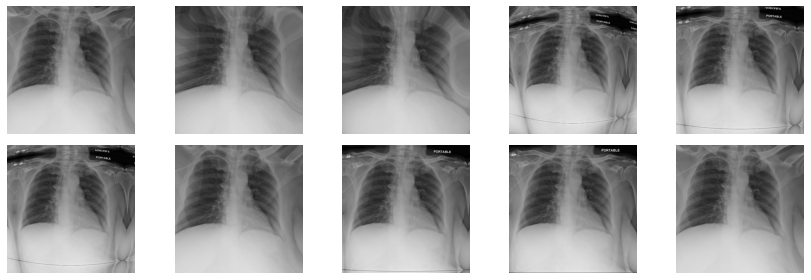

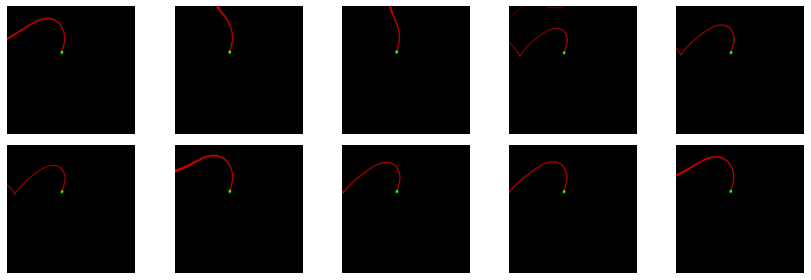

In [ ]:
optical_distortion = OpticalDistortion(
    distort_limit=1.0, shift_limit=0.05, p=0.75)
check_aug(optical_distortion, with_mask=True)

### GridDistortion

In [ ]:
def make_grid_distorted_maps(height, width, num_steps, xsteps, ysteps):
    def _make_maps_before_last(size, step, steps): # size=512, step=102,
                                                   # steps.shape=[num_steps]
        step_rep = tf.repeat(step, num_steps)  # [102, 102, 102, 102, 102]
        step_rep_f = tf.cast(step_rep, dtype=tf.float32)
        step_inc = step_rep_f * steps          # [102*s_0, ..., 102*s_4]
        cur = tf.math.cumsum(step_inc)         # [si_0, si_0 + si_1, ... ]
        zero = tf.zeros([1], dtype=tf.float32)
        prev = tf.concat([ zero, cur[ :-1] ], axis=0) # [0, c_0, ..., c_3]
        prev_cur = tf.stack([prev, cur])       # [[p_0, p_1, ...], [c_0, c_1, ...]]
        ranges = tf.transpose(prev_cur)        # [[p_0, c_0], [p_1, c_1], ... ]

        def _linspace_range(rng):
            return tf.linspace(rng[0], rng[1], step)
 
        maps_stack = tf.map_fn(_linspace_range, ranges)
        maps = tf.reshape(maps_stack, [-1])    # [-1] flatten into 1-D
        return maps
    
    def _make_last_map(size, step, last_start):
        last_step = size - step * num_steps  # 512 - 102*5 = 2 
        size_f = tf.cast(size, dtype=tf.float32)
        last_map = tf.linspace(last_start, size_f-1.0, last_step)
        return last_map
    
    def _make_distorted_map(size, steps):
        step = size // num_steps               # step=102 
        maps_before_last = _make_maps_before_last(size, step, steps[ :-1 ])
        last_map = _make_last_map(size, step, maps_before_last[-1])
        distorted_map = tf.concat([maps_before_last, last_map], axis=0)
        return distorted_map

    xx = _make_distorted_map(width, xsteps)
    yy = _make_distorted_map(height, ysteps)
    map_y, map_x = tf.meshgrid(xx, yy)
    return map_x, map_y

def GridDistortion(num_steps, distort_limit, p=1.0):
    def _do_grid_distortion(image, mask):
        xsteps = tf.random.uniform(
            [num_steps + 1],
            minval=1.0 - distort_limit,
            maxval=1.0 + distort_limit)
        ysteps = tf.random.uniform(
            [num_steps + 1],
            minval=1.0 - distort_limit,
            maxval=1.0 + distort_limit)

        image_shape = tf.shape(image)
        height = image_shape[0]
        width = image_shape[1]
        map_x, map_y = make_grid_distorted_maps(
            height, width, num_steps, xsteps, ysteps)
        aug_image = remap(
            image, height, width, map_x, map_y, mode='mirror')
        aug_mask = remap(
            mask, height, width, map_x, map_y, mode='mirror')
        return choice(p, aug_image, aug_mask, image, mask)
    return _do_grid_distortion

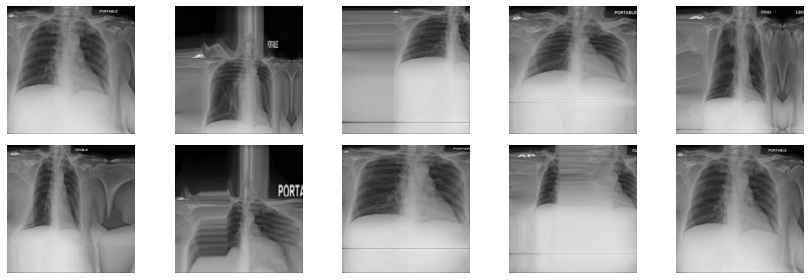

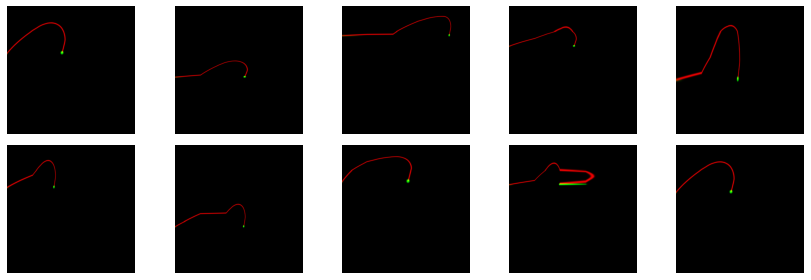

In [ ]:
grid_distortion = GridDistortion(
    num_steps=5, distort_limit=1.0, p=0.75)
check_aug(grid_distortion, with_mask=True)

### OneOf

In [ ]:
def OneOf(trans1, trans2, p):
    def _do_one_of(image, mask):
        image1, mask1 = trans1(image, mask)
        image2, mask2 = trans2(image, mask)
        aug_image, aug_mask = choice(
            0.5, image1, mask1, image2, mask2)
        return choice(p, aug_image, aug_mask, image, mask)
    return _do_one_of

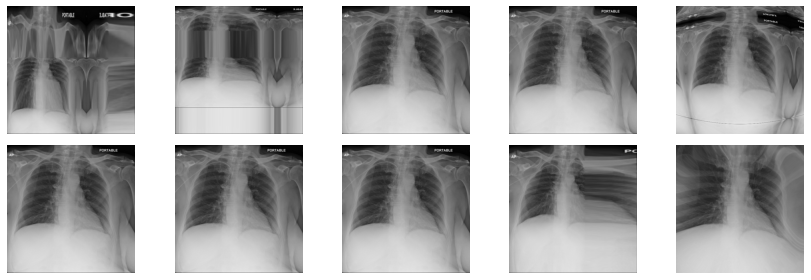

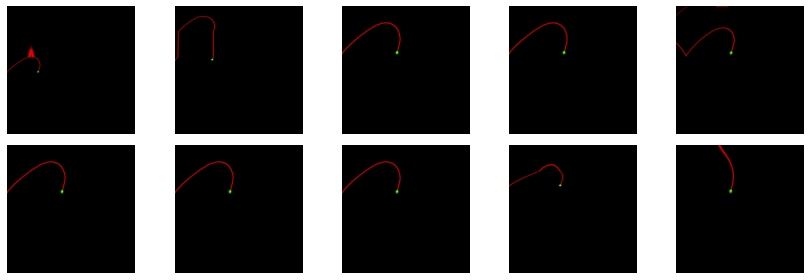

In [ ]:
one_of_opt_grid_distortion = OneOf(
    optical_distortion, grid_distortion, p=0.75)
check_aug(one_of_opt_grid_distortion, with_mask=True)

### HeuSaturationValue

In [ ]:
def HueSaturationValue(
        hue_shift_limit, sat_shift_limit, val_shift_limit, p):
    def _do_hue_saturation_value(image, mask):
        hsv_image = tf.image.rgb_to_hsv(image)
        hue_shift = random_float(-hue_shift_limit, hue_shift_limit)
        sat_shift = random_float(-sat_shift_limit, sat_shift_limit)
        val_shift = random_float(-val_shift_limit, val_shift_limit)

        hue_values = (hsv_image[ ... , :1 ] + hue_shift) % 1.0
        sat_values = tf.clip_by_value(
            hsv_image[ ... , 1:2 ] + sat_shift, 0.0, 1.0)
        val_values = tf.clip_by_value(
            hsv_image[ ... , 2: ] + val_shift, 0.0, 1.0)
        hsv_image = tf.concat(
            [hue_values, sat_values, val_values], axis=-1)
        aug_image = tf.image.hsv_to_rgb(hsv_image)
        return choice(p, aug_image, mask, image, mask)
    return _do_hue_saturation_value

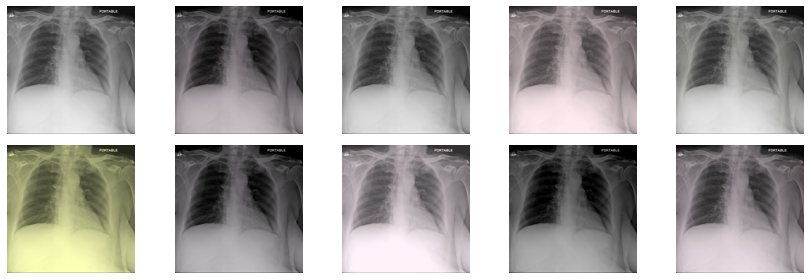

In [ ]:
hue_saturation_value = HueSaturationValue(
    hue_shift_limit=0.2, sat_shift_limit=0.3,
    val_shift_limit=0.2, p=0.75)
check_aug(hue_saturation_value, with_mask=False)

### ShiftScaleRotate

In [ ]:
def affine_transform(height, width, tx, ty, z, theta):
    cx = (width - 1.0) * 0.5
    cy = (height - 1.0) * 0.5
    
    center_shift_mat = tf.convert_to_tensor([
        [1.0, 0.0, -cx],
        [0.0, 1.0, -cy],
        [0.0, 0.0, 1.0]], dtype=tf.float32)
    trans_mat = center_shift_mat
    
    rot_rad = -2.0 * math.pi * theta / 360.0
    roration_mat = tf.convert_to_tensor([
        [tf.math.cos(rot_rad), tf.math.sin(rot_rad), 0.0],
        [-tf.math.sin(rot_rad), tf.math.cos(rot_rad), 0.0],
        [0.0, 0.0, 1.0]], dtype=tf.float32)
    trans_mat = tf.linalg.matmul(roration_mat, trans_mat)
    
    shift_mat = tf.convert_to_tensor([
        [1.0, 0.0, cx - tx],
        [0.0, 1.0, cy - ty],
        [0.0, 0.0, 1.0]], dtype=tf.float32)
    trans_mat = tf.linalg.matmul(shift_mat, trans_mat)

    zoom_mat = tf.convert_to_tensor([
        [1.0 / z, 0.0, 0.0],
        [0.0, 1.0 / z, 0.0],
        [0.0, 0.0, 1.0]], dtype=tf.float32)
    trans_mat = tf.linalg.matmul(zoom_mat, trans_mat)
    
    h_rng = tf.range(height, dtype=tf.float32)
    w_rng = tf.range(width, dtype=tf.float32)
    y, x = tf.meshgrid(h_rng, w_rng)
    x = tf.reshape(x, [-1])
    y = tf.reshape(y, [-1])
    ones = tf.ones_like(x)
    coord_mat = tf.stack([x, y, ones])
    
    res_mat = tf.linalg.matmul(trans_mat, coord_mat)
    map_x = res_mat[0]
    map_y = res_mat[1]
    return map_x, map_y

In [ ]:
def ShiftScaleRotate(
        shift_limit, scale_limit, rotate_limit, p):
    def _do_shift_scale_rotate(image, mask):
        image_shape = tf.shape(image)
        height_i = image_shape[0]
        width_i = image_shape[1]
        height_f = tf.cast(height_i, dtype=tf.float32)
        width_f = tf.cast(width_i, dtype=tf.float32)
        tx = width_f * random_float(-shift_limit, shift_limit)
        ty = height_f * random_float(-shift_limit, shift_limit)
        z = random_float(1.0 - scale_limit, 1.0 + scale_limit)
        theta = random_float(-rotate_limit, rotate_limit)

        map_x, map_y = affine_transform(
            height_f, width_f, tx, ty, z, theta)
        aug_image = remap(
            image, height_i, width_i, map_x, map_y, mode='constant')
        aug_mask = remap(
            mask, height_i, width_i, map_x, map_y, mode='constant')
        return choice(p, aug_image, aug_mask, image, mask)
    return _do_shift_scale_rotate

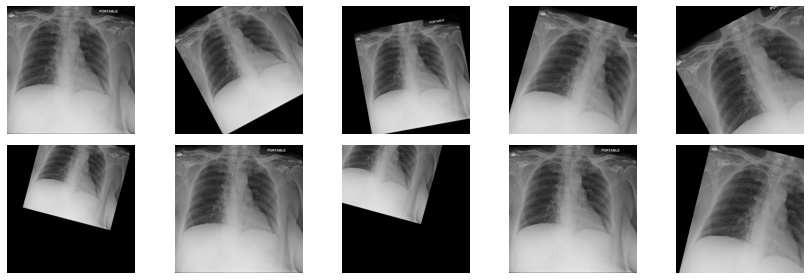

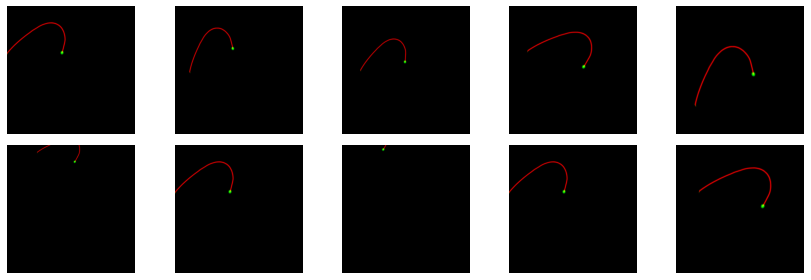

In [ ]:
shift_scale_rotate = ShiftScaleRotate(
    shift_limit=0.2, scale_limit=0.3, rotate_limit=30, p=0.75)
check_aug(shift_scale_rotate, with_mask=True)

## Cutout

In [ ]:
def randints(shape, minval, maxval):
    # maxval+1 to include maxval for the result.
    # generated range is [minval, maxval) (maxval is not included)
    return tf.random.uniform(
        shape=shape, minval=minval, maxval=maxval+1, dtype=tf.int32)

def make_range_masks(size, starts, ends):
    indice = tf.range(size, dtype=tf.int32)
    start_masks = (
        starts[ : , tf.newaxis] <= indice[  tf.newaxis, : ])
    end_masks = (
        indice[ tf.newaxis, : ] <= ends[ : , tf.newaxis])
    range_masks = start_masks & end_masks
    return range_masks

def make_region_mask(tops, lefts, bottoms, rights):
    row_masks = make_range_masks(image_size, tops, bottoms)
    col_masks = make_range_masks(image_size, lefts, rights)
    region_masks = \
        row_masks[ : , : , tf.newaxis ] & \
        col_masks[ : , tf.newaxis, : ]
    region_mask = tf.math.reduce_any(region_masks, axis=0)
    region_mask = region_mask[ : , : , tf.newaxis]
    return region_mask

def Cutout(num_cuts, mask_factor, p):
    def _do_cutout(image, mask):
        image_shape = tf.shape(image)
        height_i = image_shape[0]
        width_i = image_shape[1]
        height_f = tf.cast(height_i, dtype=tf.float32)
        width_f = tf.cast(width_i, dtype=tf.float32)
        cut_h = tf.cast(height_f * mask_factor, dtype=tf.int32)
        cut_w = tf.cast(width_f * mask_factor, dtype=tf.int32)

        y_centers = randints([num_cuts], 0, image_size - 1)
        x_centers = randints([num_cuts], 0, image_size - 1)
        tops = tf.math.maximum(y_centers - cut_h//2, 0)
        lefts = tf.math.maximum(x_centers - cut_w//2, 0)
        bottoms = tf.math.minimum(tops + cut_h, height_i - 1)
        rights = tf.math.minimum(lefts + cut_w, width_i - 1)

        cut_region = make_region_mask(tops, lefts, bottoms, rights)
        mask_value = tf.constant(0.0, dtype=tf.float32)
        aug_image = tf.where(cut_region, mask_value, image)
        return choice(p, aug_image, mask, image, mask)
    return _do_cutout

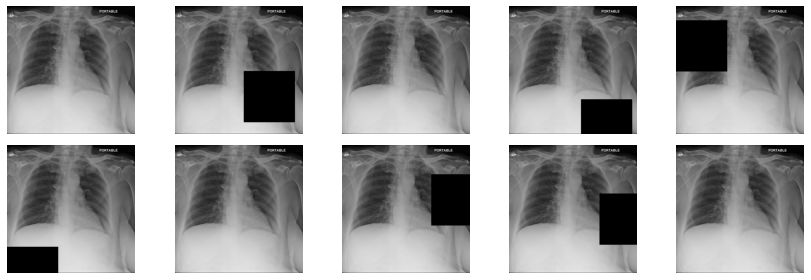

In [ ]:
cut_out = Cutout(num_cuts=1, mask_factor=0.4, p=0.75)
check_aug(cut_out, with_mask=False)

### Series of Augmentations

In [ ]:
def do_augment(image, mask, labels):
    # some tensorflow augmentation expects float
    image, mask = image_mask_to_float_0_1(image, mask)
    
    image, mask = horizontal_flip(image, mask)
    image, mask = random_brightness(image, mask)
    image, mask = random_contrast(image, mask)
    image, mask = one_of_opt_grid_distortion(image, mask)
    image, mask = hue_saturation_value(image, mask)
    image, mask = shift_scale_rotate(image, mask)
    image, mask = cut_out(image, mask)

    # back to uint8
    image, mask = image_mask_to_uint8(image, mask)
    return image, mask, labels

## Dataset 2

In [ ]:
def select_train(ds, fold):
    ds = ds.filter(lambda image, mask, labels, f: f != fold)
    return ds
    
def select_val(ds, fold):
    ds = ds.filter(lambda image, mask, labels, f: f == fold)
    return ds

In [ ]:
def drop_fold(image, mask, labels, fold):
    return image, mask, labels

def process_image_mask(image, mask, labels):
    mask = mask[ : , : , :-1 ]
    combined = tf.concat([image, mask], axis=-1)
    return combined, labels

In [ ]:
def build_dataset(
        dset, augment=True, repeat=True, shuffle=1024):
    dset = dset.map(drop_fold, num_parallel_calls=AUTOTUNE)
    dset = dset.repeat() if repeat else dset
    dset = dset.map(
        do_augment, num_parallel_calls=AUTOTUNE) if augment else dset
    dset = dset.map(process_image_mask, num_parallel_calls=AUTOTUNE)
    dset = dset.shuffle(shuffle) if shuffle else dset
    dset = dset.batch(batch_size)
    dset = dset.prefetch(AUTOTUNE)
    return dset

In [ ]:
def make_datasets(fold_i):
    train_ds = select_train(raw_ds, fold_i)
    train_ds = build_dataset(
        train_ds, augment=True, repeat=True, shuffle=1024)

    val_ds = select_val(raw_ds, fold_i)
    val_ds = build_dataset(
        val_ds, augment=False, repeat=False, shuffle=None)

    train_steps = fold_train_count(fold_i) // batch_size
    val_steps = fold_val_count(fold_i) // batch_size

    return train_ds, val_ds, train_steps, val_steps

## Visualization

In [ ]:
train_ds, val_ds, train_steps, val_steps = make_datasets(0)

print(train_ds)
print(val_ds)

<PrefetchDataset shapes: ((None, 512, 512, 5), ((None, 4), (None, 8), (None, 11))), types: (tf.uint8, (tf.int64, tf.int64, tf.int64))>
<PrefetchDataset shapes: ((None, 512, 512, 5), ((None, 4), (None, 8), (None, 11))), types: (tf.uint8, (tf.int64, tf.int64, tf.int64))>


In [ ]:
from pylab import rcParams

def show_images(ds):
    rcParams['figure.figsize'] = 20,10

    f, axarr = plt.subplots(1,5)
    imgs = []
    ds_iter = iter(ds.unbatch())
    for p in range(5):
        img, labels = next(ds_iter)
        axarr[p].imshow(img[ : , : , :3 ])
        imgs.append(img)

    f, axarr = plt.subplots(1,5)
    for p in range(5):
        axarr[p].imshow(imgs[p][ : , : , 3])

    f, axarr = plt.subplots(1,5)
    for p in range(5):
        axarr[p].imshow(imgs[p][ : , : , 4])

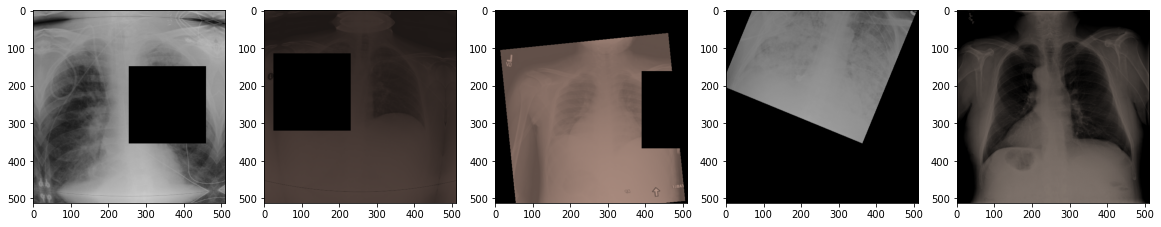

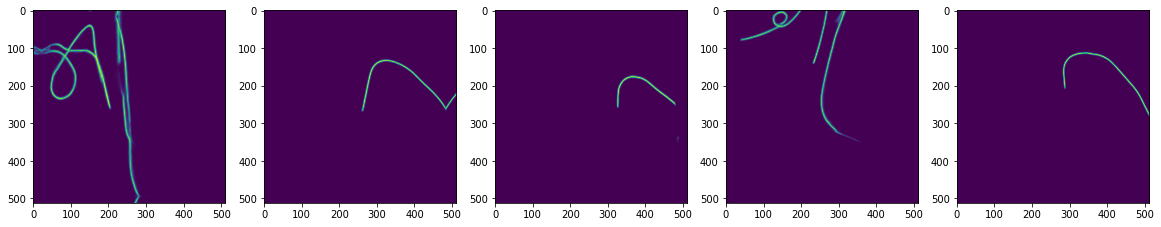

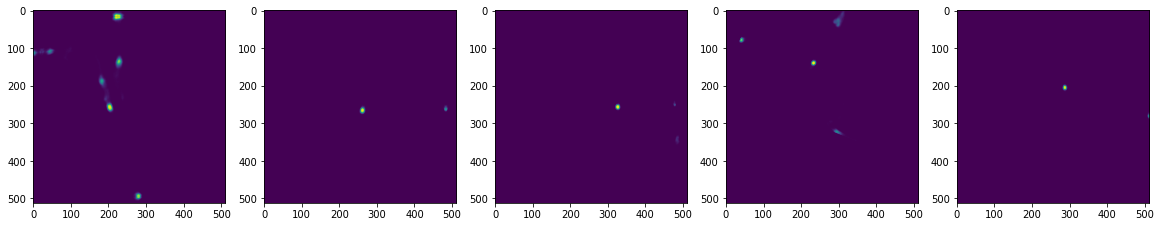

In [ ]:
show_images(train_ds)

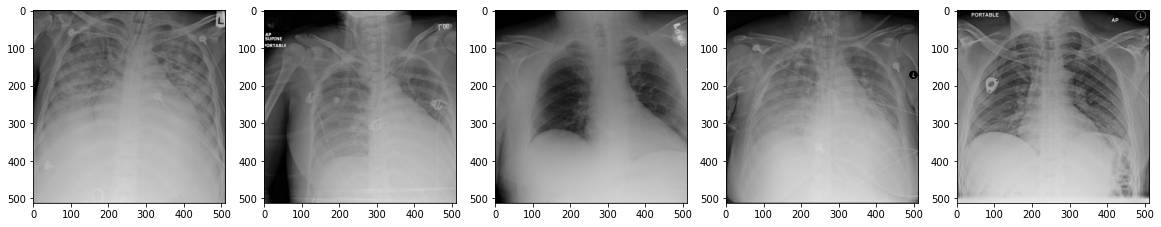

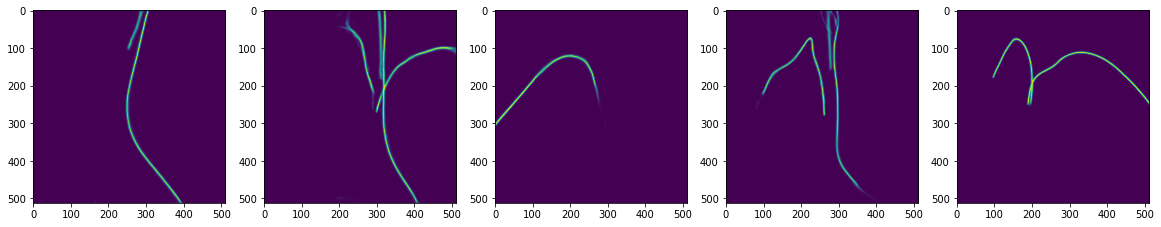

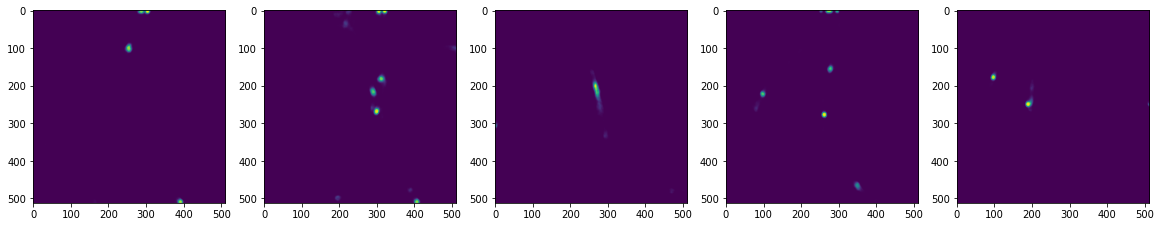

In [ ]:
show_images(val_ds)

## Model

Reference: _clone_layer() function in https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/keras/models.py

In [ ]:
def clone_layer(layer):
    config = layer.get_config()
    return layer.__class__.from_config(config)

Reference: [How to replace (or insert) intermediate layer in Keras model?](https://stackoverflow.com/questions/49492255/how-to-replace-or-insert-intermediate-layer-in-keras-model)

In [ ]:
def make_input_layers_dict(enet_3_ch, stem_conv_index):
    input_layers_dict = {}
    for layer in enet_3_ch.layers[ stem_conv_index: ]:
        for node in layer._outbound_nodes:
            layer_name = node.outbound_layer.name
            if layer_name not in input_layers_dict:
                input_layers_dict[layer_name] = [layer.name]
            else:
                input_layers_dict[layer_name].append(layer.name)
    return input_layers_dict

In [ ]:
def call_layers(enet_3_ch, stem_conv_index, input_layers_dict, x):
    new_output_tensor_dict = {
        "stem_conv": x
    }
    model_outputs = []
    for layer in enet_3_ch.layers[ stem_conv_index + 1: ]:
        # Determine input tensors
        layer_input = [
            new_output_tensor_dict[layer_aux] 
            for layer_aux in input_layers_dict[layer.name] ]
        if len(layer_input) == 1:
            layer_input = layer_input[0]

        x = layer(layer_input)
        new_output_tensor_dict[layer.name] = x

        if layer.name in enet_3_ch.output_names:
            model_outputs.append(x)

    return model_outputs

In [ ]:
def make_normalization_n_ch_weights(weights_3_ch):
    # [ mean, stdev, bias ]
    weight_3_0 = weights_3_ch[0]
    weight_n_0 = np.concatenate(
        [ weight_3_0, weight_3_0[ :(n_ch - 3)] ])
    
    weight_3_1 = weights_3_ch[1]
    weight_n_1 = np.concatenate(
        [ weight_3_1, weight_3_1[ :(n_ch - 3)] ])
    
    weight_n_2 = weights_3_ch[2]
    
    weights_n_ch = [weight_n_0, weight_n_1, weight_n_2]
    return weights_n_ch

In [ ]:
def make_stem_conv_n_ch_weights(weights_3_ch):
    # [ coefficient, bias ]
    # stem_conv does not use bias, so only has one weight.
    weight_3_0 = weights_3_ch[0]
    weight_n_0 = np.concatenate(
        # [ filter_height, filter_width, in_channel, out_channel ]
        [ weight_3_0, weight_3_0[ : , : , :(n_ch - 3), : ]], axis=2)
    return [ weight_n_0 ]

In [ ]:
def make_n_ch_enet():
    # Make a model with pretrained weight as usual.
    enet_3_ch = enet_type(
        include_top=False, weights='imagenet',
        input_shape=(image_size, image_size, 3),
        pooling='avg')
    
    stem_conv_index = 4
    assert \
        enet_3_ch.layers[stem_conv_index].name == "stem_conv", \
        "Efn layer 4 is not 'stem_conv'"
    
    input_layers_dict = \
        make_input_layers_dict(enet_3_ch, stem_conv_index)
    
    # Clone layers that need to change the weight for 5 channel input.
    rescaling = enet_3_ch.layers[1]
    normalization_3_ch = enet_3_ch.layers[2]
    normalization_n_ch = clone_layer(normalization_3_ch)
    stem_conv_pad = enet_3_ch.layers[3]
    stem_conv_3_ch = enet_3_ch.layers[stem_conv_index]
    stem_conv_n_ch = clone_layer(stem_conv_3_ch)

    # Make a 5 channel input layer, then call.
    n_ch_inputs = tf.keras.Input(
        shape=(image_size, image_size, n_ch), name="enet_n_ch_inputs")
    x = n_ch_inputs
    x = rescaling(x)
    x = normalization_n_ch(x)
    x = stem_conv_pad(x)
    x = stem_conv_n_ch(x)
    n_ch_outputs = call_layers(
        enet_3_ch, stem_conv_index, input_layers_dict, x)
    
    enet_n_ch = tf.keras.Model(
        inputs=n_ch_inputs, outputs=n_ch_outputs, name="enet_n_ch")
    
    # Set weight to the clone layers for 5 input channels.
    normalization_weights_3_ch = normalization_3_ch.get_weights()
    normalization_weights_n_ch = \
        make_normalization_n_ch_weights(normalization_weights_3_ch)
    normalization_n_ch.set_weights(normalization_weights_n_ch)
    
    stem_conv_weights_3_ch = stem_conv_3_ch.get_weights()
    stem_conv_weights_n_ch = \
        make_stem_conv_n_ch_weights(stem_conv_weights_3_ch)
    stem_conv_n_ch.set_weights(stem_conv_weights_n_ch)
    
    return enet_n_ch

In [ ]:
def make_pred_output(x):
    ett = x[0]
    other = x[1]
    ett_wo_no_ett = ett[ : , :3 ]
    pred = tf.concat([ett_wo_no_ett, other], axis=-1)
    return pred

def make_model():
    with strategy.scope(): 
        enet = make_n_ch_enet()
        
        inputs = tf.keras.Input(
            shape=(image_size, image_size, n_ch), name="inputs")
        x = enet(inputs)
        x = L.Dropout(0.5, name='dropout')(x)
        output_ett = L.Dense(
            num_ett_classes, activation='softmax', name='ett')(x)
        output_other = L.Dense(
            num_other_classes, activation='sigmoid', name='other')(x)
        output_pred = L.Lambda(
            make_pred_output, name='pred')([output_ett, output_other])

        model = tf.keras.Model(
            inputs=inputs,
            outputs=[output_ett, output_other, output_pred],
            name="cls_model")

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss={
            "ett": "categorical_crossentropy",
            "other": "binary_crossentropy" },
        loss_weights={
            "ett": loss_weights[0] / sum(loss_weights),
            "other": loss_weights[1] / sum(loss_weights) },
        metrics={
            "pred": tf.keras.metrics.AUC(multi_label=True, name="auc") },
        # overheads and allows the XLA compiler to unroll the loop on TPU
        # and optimize hardware utilization.
        # needs to be commented out for Tensorflow 2.3
        steps_per_execution=8)
    model.summary()

    return model

In [ ]:
model = make_model()
initial_weights = model.get_weights()

27025408/27018416 [==============================] - 0s 0us/step
Model: "cls_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 512, 512, 5) 0                                            
__________________________________________________________________________________________________
enet_n_ch (Functional)          (None, 1280)         6575819     inputs[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 1280)         0           enet_n_ch[0][0]                  
__________________________________________________________________________________________________
ett (Dense)                     (None, 4)            5124        dropout[0][0]                    
_________________________

## Training

Learning rate schedule: 0.0003 to 0.001 to 1e-05


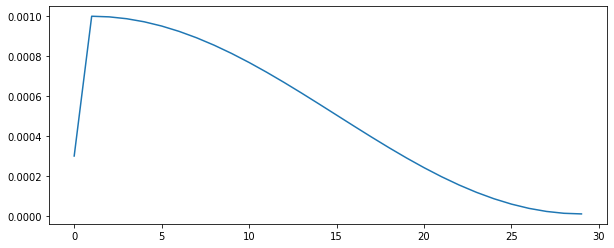

In [ ]:
LR_START = init_lr
LR_MAX = 1e-3
LR_MIN = 1e-5
LR_RAMPUP_EPOCHS = warmup_epo
LR_SUSTAIN_EPOCHS = 0
EPOCHS = n_epochs

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        decay_total_epochs = EPOCHS - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1
        decay_epoch_index = epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
        phase = math.pi * decay_epoch_index / decay_total_epochs
        cosine_decay = 0.5 * (1 + math.cos(phase))
        lr = (LR_MAX - LR_MIN) * cosine_decay + LR_MIN
    return lr

rng = [i for i in range(EPOCHS)]
lr_y = [lrfn(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, lr_y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}". \
      format(lr_y[0], max(lr_y), lr_y[-1]))

In [ ]:
cb_monitor = 'val_pred_auc'

class RestoreBestWeights(tf.keras.callbacks.Callback):
    def __init__(self):
        super(RestoreBestWeights, self).__init__()
        self.best_monitor = -np.Inf
        self.best_weights = None
        self.best_epoch = None
        
    def on_epoch_end(self, epoch, logs=None):
        current_monitor = logs.get(cb_monitor)
        if current_monitor > self.best_monitor:
            self.best_monitor = current_monitor
            self.best_weights = self.model.get_weights()
            self.best_epoch = epoch
            
    def on_train_end(self, logs=None):
        print("Restoring best weights on epoch {0}, {1} was {2:.5f}".format(
            self.best_epoch + 1, cb_monitor, self.best_monitor))
        self.model.set_weights(self.best_weights)

In [ ]:
def make_callbacks(fold_i):
    best_model_file_name = "cls_model_{0}_{1}.hdf5".format(VID, fold_i)
    cb_mode = 'max'
    cb_min_delta = 1e-4
    cb_verbose = 1

    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        best_model_file_name, save_best_only=True,
        save_weights_only=False, monitor=cb_monitor, mode=cb_mode,
        verbose=cb_verbose)
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = False)
    restore_best_weights = RestoreBestWeights()
    
    return checkpoint, lr_callback, restore_best_weights

In [ ]:
def fit_one_fold(fold_i):
    train_dataset, val_dataset, train_steps, val_steps = \
        make_datasets(fold_i)
    checkpoint, lr_callback, restore_best_weights = \
        make_callbacks(fold_i)
    history = model.fit(
        train_dataset, 
        epochs=EPOCHS,
        verbose=1,
        callbacks=[checkpoint, lr_callback, restore_best_weights],
        steps_per_epoch=train_steps,
        validation_data=val_dataset,
        validation_steps=val_steps)
    return history, val_dataset, val_steps

In [ ]:
def plot_history(history, title, labels, subplot):
    plt.subplot(*subplot)
    plt.title(title)
    for label in labels:
        plt.plot(history.history[label], label=label)
    plt.legend()

In [ ]:
def plot_fit_result(history):
    plt.figure(figsize=(12, 4))
    plot_history(
        history,
        "Loss", ['loss', 'val_loss'], (1, 2, 1))
    plot_history(
        history,
        "AUC", ['pred_auc', 'val_pred_auc'], (1, 2, 2))
    plt.show()

In [ ]:
def predict_one_fold(model, val_dataset, val_steps):
    val_true_list = [] 
    for _, (_, _, labels_pred) in val_dataset:
        val_true_list.append(labels_pred)
    val_true = np.concatenate(val_true_list, axis=0)
   
    # Causes the error :ValueError: The two structures don't have
    # the same nested structure.
    # val_preds = model.predict(val_dataset, steps=val_steps)
    # val_pred = val_preds[2]
    val_pred_list = []
    for val_data in val_dataset:
        val_preds = model(val_data[0], training=False)
        val_pred_list.append(val_preds[2])
    val_pred = np.concatenate(val_pred_list, axis=0)
    
    val_true = val_true[ : len(val_pred) ]
    return val_true, val_pred

In [ ]:
target_columns = [
    'ETT - Abnormal',
    'ETT - Borderline',
    'ETT - Normal',
    'NGT - Abnormal',
    'NGT - Borderline',
    'NGT - Incompletely Imaged',
    'NGT - Normal',
    'CVC - Abnormal',
    'CVC - Borderline',
    'CVC - Normal',
    'Swan Ganz Catheter Present',
]

In [ ]:
from sklearn.metrics import roc_auc_score

def show_roc_auc_score(val_true, val_pred):
    auc_list = []
    for i in range(val_true.shape[-1]):
        auc = roc_auc_score(val_true[ : , i], val_pred[ : , i])
        print("{0:30s}: {1:.4f}".format(target_columns[i], auc))
        auc_list.append(auc)

    mean_auc = np.mean(auc_list)
    print("{0:30s}: {1:.4f}".format("Mean", mean_auc))
    
    plt.figure(figsize=(8, 4))
    plt.plot(auc_list)
    ticks = np.arange(len(target_columns))
    plt.xticks(ticks=ticks, labels=target_columns, rotation=90)
    plt.show()

####################
# Fold 0
Epoch 1/30
188/188 [==============================] - 559s 3s/step - loss: 0.3285 - ett_loss: 0.4667 - other_loss: 0.3131 - pred_auc: 0.7428 - val_loss: 0.2027 - val_ett_loss: 0.1593 - val_other_loss: 0.2075 - val_pred_auc: 0.9152

Epoch 00001: val_pred_auc improved from -inf to 0.91516, saving model to cls_model_V19_0.hdf5
Epoch 2/30
188/188 [==============================] - 432s 2s/step - loss: 0.2111 - ett_loss: 0.2206 - other_loss: 0.2100 - pred_auc: 0.8775 - val_loss: 0.2003 - val_ett_loss: 0.1940 - val_other_loss: 0.2010 - val_pred_auc: 0.9237

Epoch 00002: val_pred_auc improved from 0.91516 to 0.92369, saving model to cls_model_V19_0.hdf5
Epoch 3/30
188/188 [==============================] - 435s 2s/step - loss: 0.1843 - ett_loss: 0.1754 - other_loss: 0.1853 - pred_auc: 0.9162 - val_loss: 0.1978 - val_ett_loss: 0.1481 - val_other_loss: 0.2033 - val_pred_auc: 0.9311

Epoch 00003: val_pred_auc improved from 0.92369 to 0.93109, saving model to cls_mod

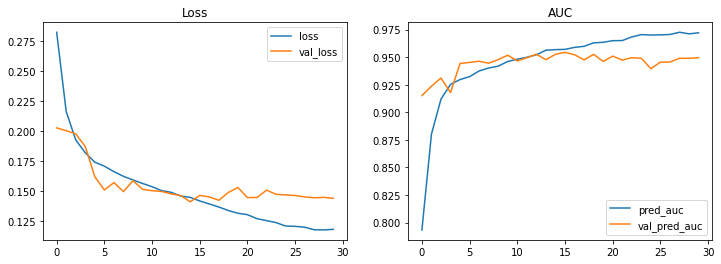

ETT - Abnormal                : 0.9376
ETT - Borderline              : 0.9644
ETT - Normal                  : 0.9919
NGT - Abnormal                : 0.9781
NGT - Borderline              : 0.9753
NGT - Incompletely Imaged     : 0.9859
NGT - Normal                  : 0.9876
CVC - Abnormal                : 0.9158
CVC - Borderline              : 0.8777
CVC - Normal                  : 0.9276
Swan Ganz Catheter Present    : 0.9988
Mean                          : 0.9583


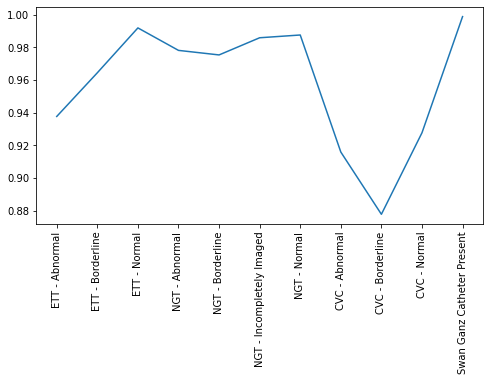

In [ ]:
for fold_i in FOLD_I_LIST:
    print("####################")
    print("# Fold {0}".format(fold_i))
    model.set_weights(initial_weights)
    history, val_dataset, val_steps = fit_one_fold(fold_i)
    plot_fit_result(history)
    val_true, val_pred = predict_one_fold(model, val_dataset, val_steps)
    show_roc_auc_score(val_true, val_pred)